In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
import random
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import mglearn

In [2]:
data = pd.read_csv('/Users/Akashgupta/Desktop/parsedrev.csv')
#data = data.rename(columns={"LENOVO": "REVIEW"})
#lab = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/GOLD_LABELS_len.csv')

In [9]:
data = pd.read_csv('/Users/Akashgupta/Desktop/parsedrev.csv')
data

,Unnamed: 0,REVIEW,LABELS
0,0,using last days laptop main usage development ...,neg
1,1,got detective laptop didn't turn worst custome...,neg
2,2,guys bought dell laptop week ago amazon which ...,pos
3,3,after using about month good specs performance...,pos
4,4,using product days no issues all laptop boot t...,pos
...,...,...,...
1992,1992,not satisfied battery life,neg
1993,1993,decent product price,pos
1994,1994,meeting expectations,pos
1995,1995,value money good speed,pos


In [10]:
labs = []
for i in range(len(data['LABELS'])):
    if data['LABELS'][i] == 'neg':
        labs.append(0)
    elif data['LABELS'][i] == 'pos':
        labs.append(1)

In [11]:
data['LAB'] = labs

In [12]:
data

,Unnamed: 0,REVIEW,LABELS,LAB
0,0,using last days laptop main usage development ...,neg,0
1,1,got detective laptop didn't turn worst custome...,neg,0
2,2,guys bought dell laptop week ago amazon which ...,pos,1
3,3,after using about month good specs performance...,pos,1
4,4,using product days no issues all laptop boot t...,pos,1
...,...,...,...,...
1992,1992,not satisfied battery life,neg,0
1993,1993,decent product price,pos,1
1994,1994,meeting expectations,pos,1
1995,1995,value money good speed,pos,1


In [15]:
class L_stats(object):
    def __init__(self, raw, col_name):
        self.raw = raw
        self.col_name = col_name
        
    def tokenized(self):
        tokens = []
        for review in self.raw[self.col_name]:
            tokens.append([w.lower() for w in nltk.word_tokenize(review) if len(w)>1])
        return tokens
    
    def bi_token(self):
        bitokens = []
        tokendata = self.tokenized()
        for review in tokendata:
            bitokens.append(list(nltk.bigrams(review)))
        return bitokens
    
    def vocab(self):
        voc = []
        for review in self.raw[self.col_name]:
            voc += [w.lower() for w in nltk.word_tokenize(review) if len(w)>1]
        return voc
    
    def tokenized_uni(self):
        tokens = []
        for review in self.raw[self.col_name]:
            tokens.append(list(set([w.lower() for w in nltk.word_tokenize(review) if len(w)>1])))
        return tokens
    
    def vocab_uni(self):
        voc = []
        for review in self.raw[self.col_name]:
            voc += [w.lower() for w in nltk.word_tokenize(review) if len(w)>1]
        return list(set(voc))
    
    def avg_word_count(self):
        avg = 0
        v = self.tokenized()
        for review in v:
            avg += (len(review)/len(v))
        avg = np.round(avg, 2)
        return avg
    
    def tokenized_no_stops(self):
        DF = []
        c = self.tokenized()
        for r in c:
            DF.append([w.lower() for w in r if w.lower() not in stopwords.words('english')])
        return DF
    
    def vocab_no_stops(self):
        v = self.vocab()
        d = [w.lower() for w in v if w.lower() not in stopwords.words('english')]
        return d
    
    def count_stats(self):
        print("Total number of words in all reviews: ", len(self.vocab()))
        print()
        print("Average number of words in each review: ", self.avg_word_count())
        print()
        print("Total number of words in all reviews without stopwords", len(self.vocab_no_stops()))
         
    def frequencies(self):
        print("Top 60 most frequently occurring words in the dataset, along with their count:")
        print()
        var2 = nltk.FreqDist(self.vocab()).most_common(60)
        for i in range(60):
            print(var2[i])
    
    def frequencies_stop(self):
        print("Top 30 most frequently occurring words in the data without stops, along with their count:")
        print()
        var = nltk.FreqDist(self.vocab_no_stops()).most_common(30)
        for i in range(30):
            print(var[i])
    
    def hapaxes(self):
        print("Top 60 most rare words that occur only once in the review dataset:")
        print()
        vvv = self.vocab()
        var3 = nltk.FreqDist(vvv).hapaxes()
        for i in range(60):
            print(var3[i])
            
    def collocation(self):
        print("Most frequent bigrams (pairs of words): ")
        print()
        v4 = self.vocab()
        t = nltk.Text(v4)
        print(t.collocations_list())
        #print()
        #dft = self.tokenized()
        #for r in dft:
            #t = nltk.Text(r)
            #if t.collocations() != None:
                #print(t.collocations())
                
    def concord(self, word):
        vs = self.vocab()
        tt = nltk.Text(vs)
        print(tt.concordance(word))
        
    def find_bigrams(self, word):
        vv = self.vocab()
        t6 = nltk.Text(vv)
        print(t6.findall(r'<{}> <.*>'.format(word)))
        
    def nouns(self):
        vvs = self.vocab()
        nouns = [w for (w, n) in nltk.pos_tag(vvs) if n in ['NN', 'NNP']]
        return nouns

In [16]:
DATA = L_stats(data, 'REVIEW')

In [17]:
DFL = DATA.tokenized()
reviews_all = []
for i in range(len(data['LAB'])):
    reviews_all.append((DFL[i], data['LAB'][i]))

In [18]:
random.shuffle(reviews_all)

In [19]:
freq_words = nltk.FreqDist(DATA.vocab_no_stops())
word_features = list(freq_words)

In [20]:
def review_features(review, w_feat):
    review_words = set(review)
    features = {}
    for word in w_feat:
        features['contains({})'.format(word)] = (word in review_words)
    return features

In [21]:
feature_sets = [(review_features(r, word_features), c) for (r, c) in reviews_all]
train_set, test_set = feature_sets[:1350], feature_sets[1350:]
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [22]:
nltk.classify.accuracy(classifier, test_set)

0.865533230293663

In [27]:
classifier.show_most_informative_features(360)

Most Informative Features
         contains(worst) = True                0 : 1      =     28.6 : 1.0
         contains(waste) = True                0 : 1      =     25.9 : 1.0
        contains(return) = True                0 : 1      =     16.7 : 1.0
         contains(hangs) = True                0 : 1      =     13.7 : 1.0
     contains(excellent) = True                1 : 0      =     13.4 : 1.0
      contains(horrible) = True                0 : 1      =     12.7 : 1.0
          contains(easy) = True                1 : 0      =     12.5 : 1.0
  contains(disappointed) = True                0 : 1      =     12.1 : 1.0
         contains(seems) = True                0 : 1      =     11.8 : 1.0
          contains(nice) = True                1 : 0      =     10.7 : 1.0
          contains(best) = True                1 : 0      =     10.5 : 1.0
       contains(amazing) = True                1 : 0      =      9.8 : 1.0
          contains(love) = True                1 : 0      =      9.8 : 1.0

In [51]:
L1_neg = ["worst", "waste", "return", "hangs", "horrible", "disappointed"]

L1_pos = ["excellent", "easy", "nice", "best"]

L1NEG = pd.DataFrame()
L1NEG['word'] = L1_neg

L1POS = pd.DataFrame()
L1POS['word'] = L1_pos

In [52]:
L2_neg = ["defective", "minutes", "customer", "pathetic", "poor", "customers", "fault",
          "replacement", "request", "slow", "board", "replace", "serial", "suddenly"]

L2_pos = ["amazing", "love", "premium", "awesome", "weight"]

L2NEG = pd.DataFrame()
L2NEG['word'] = L2_neg

L2POS = pd.DataFrame()
L2POS['word'] = L2_pos

In [53]:
L3_neg = ["help", "repair", "browser", "defect", "flickering", "local", "unable", "hang",
          "starting", "centre", "motherboard", "mins", "click", "contacted", "replacing", 
          "terrible", "turning" ]

L3_pos = ["budget", "light", "design", "value", "fingerprint", "slim", "range", "doubt",
          "pc", "sensor", "students", "browsing"]

L3NEG = pd.DataFrame()
L3NEG['word'] = L3_neg

L3POS = pd.DataFrame()
L3POS['word'] = L3_pos

In [54]:
L4_neg = ["error", "replaced", "warranty", "bad", "plastic", "disappointing", 
          "policy", "authorised", "avoid", "emi", "service", "charger", "complaint", "crashed",
          "damaged", "heats", "extremely", "hanging", "technician",
          "cheap", "accessories", "background", "chinese", "country",
          "crazy", "detect", "fool", "lan", "material", "repaired", "respond", "router",
          "satisfactory", "connectivity", "heated", "kids", "resolved",
          "amazon", "damage", "noise", "india", "mistake", "refund", "restart",
          "batterylife", "bright", "brightness", "clarity", "crashes", "diagnosis",
          "difficult", "disadvantage", "drains", "drops", "extensive", "fragile",
          "freezing", "gpu"]

L4_pos = ["sleek", "perfect", "fast", "definitely", "external", "great", "startup",
          "portable", "thin", "feature", "size", "wonderful", "smooth", "gen",
          "decent", "coding", "developer", "impression", "personal",
          "responsive", "strong", "thank", "typing", "write", "super", "editing", "seconds",
          "student", "liked", "sturdy", "speed", "games", "absolutely", "core", "asus",
          "compact", "cool", "programmer", "discount", "lid", "flipkart", "ports",
          "smoothly", "features", "metal", "price", "antivirus", "gestures", "glare",
          "surfing", "thunderbolt", "speakers", "ssd"]

L4NEG = pd.DataFrame()
L4NEG['word'] = L4_neg

L4POS = pd.DataFrame()
L4POS['word'] = L4_pos

In [55]:
L1NEG.to_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/l1neg.csv')
L1POS.to_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/l1pos.csv')

L2NEG.to_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/l2neg.csv')
L2POS.to_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/l2pos.csv')

L3NEG.to_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/l3neg.csv')
L3POS.to_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/l3pos.csv')

L4NEG.to_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/l4neg.csv')
L4POS.to_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/l4pos.csv')

In [28]:
lex1 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/N_NEG_LEX.csv')
lex2 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/N_POS_LEX.csv')
lex3 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/onlyNEG.csv')
lex4 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/onlyPOS.csv')

In [30]:
lex3

,word,sentiment
0,heat,negative
1,heating,negative
2,heats,negative
3,heated,negative
4,2-faces,negative
...,...,...
4780,zaps,negative
4781,zealot,negative
4782,zealous,negative
4783,zealously,negative


In [11]:
negative_NEG = list(lex1['word'])
positive_NEG = list(lex2['word'])
negative_ONLY = list(lex3['word'])
positive_ONLY = list(lex4['word'])

In [31]:
lex5 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/bi_NEG.csv')
lex6 = pd.read_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/bi_POS.csv')

In [32]:
lex5

,word1,word2
0,no,issues
1,not,heat
2,no,issues
3,no,lags
4,no,problem
...,...,...
119,no,complains
120,no,problem
121,no,issues
122,no,issues


In [16]:
neg_bi = [tuple(x) for x in list(lex5.values)]
pos_bi = [tuple(x) for x in list(lex6.values)]

In [37]:
bigrams_data = DATA.bi_token()
unigrams_data = DATA.tokenized()

In [44]:
a = ['have', 'some', 'food']
b = ['trying', 'this', 'out', 'have', 'food']

list(set(b) - set(a).intersection(set(b)))

['this', 'trying', 'out']

In [19]:
regex = r'[a-zA-Z]{4,17}'
vect = CountVectorizer(max_df=0.36, stop_words="english", token_pattern=regex)
X = vect.fit_transform(data['REVIEW'])

In [20]:
lda = LatentDirichletAllocation(n_components=3, learning_method="batch",
                                max_iter=30, random_state=0)
doc_topics = lda.fit_transform(X)

In [21]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())

In [22]:
mglearn.tools.print_topics(topics=range(3), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=3, n_words=40)

topic 0       topic 1       topic 2       
--------      --------      --------      
product       slow          good          
time          takes         battery       
amazon        battery       product       
working       just          quality       
money         better        price         
lenovo        processor     life          
waste         worst         performance   
slow          installed     poor          
worst         using         best          
office        money         like          
better        boot          slow          
service       performance   camera        
problem       minutes       nice          
days          experience    light         
month         open          gaming        
return        bought        backup        
just          usage         screen        
stopped       getting       design        
work          time          work          
months        return        hours         
purchase      lenovo        office        
need       

In [18]:
checklist1 = ["customer", "customers", "care", "support", "service",
             "replaced", "replacement", "services", "replace", "return",
             "students", "classes", "school", "option",
             "option", "issue", "experience"]

checklist2 = ["hardware", "defective", "charging", "crashed", "error", "heated", "technical", "updated",
              "installed", "display", "screen", "processor", "battery", "keyboard", "freezing",
              "hanging", "lagging", "speed", "drivers", "charger", "jack", "charge", "portable",
              "software", "sensor", "power" "performance", "games", "cooling", "office", "scanner",
              "sound", "configuration", "ports", "heat"]

checklist3 = ["premium", "looks", "weight", "heavy", "looking", "build", "design",
              "lid", "overall", "sleek", "life", "white", "blue", "colour", "quality",
              "money", "price", "value", "worth", "bucks", "cost", "range", "light"]


f1_sents = []
for i in range(len(unigrams_data)):
    for w in checklist1:
        if w in unigrams_data[i] and unigrams_data[i] not in f1_sents:
            f1_sents.append(unigrams_data[i])
            
f2_sents = []
for i in range(len(unigrams_data)):
    for w in checklist2:
        if w in unigrams_data[i] and unigrams_data[i] not in f2_sents:
            f2_sents.append(unigrams_data[i])
            
f3_sents = []
for i in range(len(unigrams_data)):
    for w in checklist3:
        if w in unigrams_data[i] and unigrams_data[i] not in f3_sents:
            f3_sents.append(unigrams_data[i])

In [19]:
f1_w_negs = []
f1_wo_negs = []
POS_BI = set(pos_bi)
NEG_BI = set(neg_bi)
lean = False

#### feature 1 ####

for i in range(len(f1_sents)):
    big = list(nltk.bigrams(f1_sents[i]))
    BIG = set(big)
    if len(set.intersection(BIG, POS_BI)) > 0 or len(set.intersection(BIG, NEG_BI)) > 0:
        if f1_sents[i] not in f1_w_negs:
            f1_w_negs.append(f1_sents[i])
    elif len(set.intersection(BIG, POS_BI)) == 0 and len(set.intersection(BIG, NEG_BI)) == 0:
        if f1_sents[i] not in f1_wo_negs:
            f1_wo_negs.append(f1_sents[i])
            
#### feature 2 ######
            
f2_w_negs = []
f2_wo_negs = []
            
for i in range(len(f2_sents)):
    big = list(nltk.bigrams(f2_sents[i]))
    BIG = set(big)
    if len(set.intersection(BIG, POS_BI)) > 0 or len(set.intersection(BIG, NEG_BI)) > 0:
        if f2_sents[i] not in f2_w_negs:
            f2_w_negs.append(f2_sents[i])
    elif len(set.intersection(BIG, POS_BI)) == 0 and len(set.intersection(BIG, NEG_BI)) == 0:
        if f2_sents[i] not in f2_wo_negs:
            f2_wo_negs.append(f2_sents[i])
            
#### feature 3 ####
            
f3_w_negs = []
f3_wo_negs = []
    
for i in range(len(f3_sents)):
    big = list(nltk.bigrams(f3_sents[i]))
    BIG = set(big)
    if len(set.intersection(BIG, POS_BI)) > 0 or len(set.intersection(BIG, NEG_BI)) > 0:
        if f3_sents[i] not in f3_w_negs:
            f3_w_negs.append(f3_sents[i])
    elif len(set.intersection(BIG, POS_BI)) == 0 and len(set.intersection(BIG, NEG_BI)) == 0:
        if f3_sents[i] not in f3_wo_negs:
            f3_wo_negs.append(f3_sents[i])

In [20]:
def negation_score(negation_list, positive_NEG, negative_NEG):
    dataset = pd.DataFrame(columns=['REVIEW', 'score'])
    for i in range(len(negation_list)):
        p_score = 0
        n_score = 0
        bb = list(nltk.bigrams(negation_list[i]))
        for br in bb:
            if br in pos_bi:
                n_score -= 1
            elif br in neg_bi:
                p_score += 1
        
        for w in negation_list[i]:
            if w in positive_NEG:
                p_score += 1
            elif w in negative_NEG:
                n_score -= 1
                
        dataset.loc[i] = [" ".join(negation_list[i]), p_score + n_score]
        
    return dataset

D11 = negation_score(f1_w_negs, positive_NEG, negative_NEG)
D21 = negation_score(f2_w_negs, positive_NEG, negative_NEG)
D31 = negation_score(f3_w_negs, positive_NEG, negative_NEG)

In [21]:
def pure_score(non_neg_list, positive_ONLY, negative_ONLY):
    dataset = pd.DataFrame(columns=['REVIEW', 'score'])
    
    for i in range(len(non_neg_list)):
        p_score = 0
        n_score = 0
        for w in non_neg_list[i]:
            if w in positive_ONLY:
                p_score += 1
            elif w in negative_ONLY:
                n_score -= 1
                
        dataset.loc[i] = [" ".join(non_neg_list[i]), p_score + n_score]
        
    return dataset

D12 = pure_score(f1_wo_negs, positive_ONLY, negative_ONLY)
D22 = pure_score(f2_wo_negs, positive_ONLY, negative_ONLY)
D32 = pure_score(f3_wo_negs, positive_ONLY, negative_ONLY)

In [22]:
rev = []
label = []
data_new = pd.DataFrame(columns=['REVIEW', 'LABELS'])
for i in range(len(data)):
    rev.append(" ".join(unigrams_data[i]))
    label.append(data['LABELS'][i])
    
data_new['REVIEW'] = rev
data_new['LABELS'] = label

In [23]:
feature1 = pd.concat([D11, D12], axis=0).reset_index(drop=True)
feature2 = pd.concat([D21, D22], axis=0).reset_index(drop=True)
feature3 = pd.concat([D31, D32], axis=0).reset_index(drop=True)

In [24]:
feature1.score.median()

-1.0

In [25]:
d1 = pd.merge(feature1, feature2, on="REVIEW", how="outer")
d1 = d1.rename({'score_x': 'customers', 'score_y': 'performance'}, axis=1)
FINAL = d1.merge(feature3, on="REVIEW", how="outer")
FINAL = FINAL.rename({'score': 'appearance_price'}, axis=1)

In [26]:
score_arr = []
for i in range(len(FINAL['REVIEW'])):
    for j in range(1, 4):
        if type(FINAL.iloc[i][j]) == int:
            a = FINAL.iloc[i][j]
            FINAL.iloc[i][j] = 1
        elif type(FINAL.iloc[i][j]) != int:
            FINAL.iloc[i][j] = 0
    score_arr.append(a)
FINAL['SCORE'] = score_arr

In [27]:
lab = []
for i in range(len(FINAL['REVIEW'])):
    if FINAL['SCORE'][i] <= 0:
        lab.append("neg")
    elif FINAL['SCORE'][i] > 0:
        lab.append("pos")

(array([  1.,   1.,   5.,  33., 125., 110.,  64.,  22.,  12.,   3.]),
 array([-10. ,  -8.1,  -6.2,  -4.3,  -2.4,  -0.5,   1.4,   3.3,   5.2,
          7.1,   9. ]),
 <a list of 10 Patch objects>)

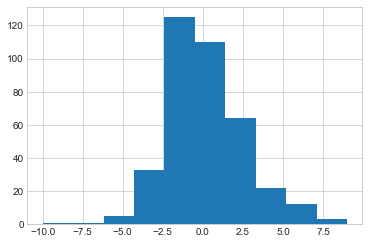

In [32]:
plt.hist(FINAL['SCORE'])

In [121]:
#lab = []
#for i in range(len(FINAL['REVIEW'])):
#    if (FINAL.iloc[i][1]<=0.0)or(FINAL.iloc[i][2]<=0.0)or(FINAL.iloc[i][3]<=0.0):
#        lab.append("neg")
#    elif (FINAL.iloc[i][1]>0.0)or(FINAL.iloc[i][2]>0.0)or(FINAL.iloc[i][3]>0.0):
#        lab.append("pos")

In [28]:
FINAL['LABELS'] = lab

In [29]:
VALID = pd.merge(data_new, FINAL[['REVIEW', 'LABELS']], on='REVIEW', how='inner')

In [30]:
counter = 0
for i in range(len(VALID)):
    if VALID['LABELS_x'][i] == VALID['LABELS_y'][i]:
        counter += 1
    else:
        pass
    
print(counter/len(VALID))

0.8461538461538461


In [32]:
brand = []
for i in range(len(FINAL['REVIEW'])):
    brand.append("LEN")
FINAL['brand'] = brand

FINAL.head()

,REVIEW,customers,performance,appearance_price,SCORE,LABELS,brand
0,'ve been using this laptop for months this goo...,1,1,1,-2,neg,LEN
1,got this 13th jan. loaded all data configured ...,1,1,1,0,neg,LEN
2,positives good design good full size keyboard ...,1,1,1,-10,neg,LEN
3,this laptop definitely not worth buying used f...,1,1,1,-4,neg,LEN
4,the viewing angles are crappy the laptop very ...,1,0,1,-4,neg,LEN


In [31]:
FINAL.head()

,REVIEW,customers,performance,appearance_price,SCORE,LABELS
0,'ve been using this laptop for months this goo...,1,1,1,-2,neg
1,got this 13th jan. loaded all data configured ...,1,1,1,0,neg
2,positives good design good full size keyboard ...,1,1,1,-10,neg
3,this laptop definitely not worth buying used f...,1,1,1,-4,neg
4,the viewing angles are crappy the laptop very ...,1,0,1,-4,neg


In [33]:
FINAL.to_csv('/Users/Akashgupta/Desktop/NEWERFIN/disser/master_LEN.csv')

In [38]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [39]:
sentence_data = []
for rev in data['REVIEW']:
    sents = nltk.sent_tokenize(rev)
    R = []
    for s in sents:
        R.append(s)
    sentence_data.append(R)

In [40]:
dd = pd.DataFrame(columns=['rev', 'lab'])
rev1 = []
lab1 = []
for sent in sentence_data:
    c = 0
    for s in sent:
        score = list(sia.polarity_scores(s).values())[3]
        c += score
    if c <= 0:
        rev1.append(" ".join(sent))
        lab1.append('neg')
    elif c > 0:
        rev1.append(" ".join(sent))
        lab1.append("pos")
    
dd['rev'] = rev1
dd['lab'] = lab1

In [41]:
rev2 = []
label2 = []
data_new2 = pd.DataFrame(columns=['REVIEW', 'LABELS'])
for i in range(len(data)):
    rev2.append(" ".join(unigrams_data[i]))
    label2.append(dd['lab'][i])
    
data_new2['REVIEW'] = rev2
data_new2['LABELS'] = label2

In [42]:
VALID2 = pd.merge(data_new, data_new2[['REVIEW', 'LABELS']], on='REVIEW', how='inner')

In [43]:
counter = 0
for i in range(len(VALID2)):
    if VALID2['LABELS_x'][i] == VALID2['LABELS_y'][i]:
        counter += 1
    else:
        pass
    
print(counter/len(VALID2))

0.8180039138943248
